# Version 4 - Succeeded!

Approach:

- Load Image
- Find Sheet corners using Canny edge detector
- Find the Largest contour of the image using openCV findContours
- Warp image to a known aspect ratio using Perspective Transform Matrix and warpPerspective
- Appy orientation fixes - rotate - flip

## For Answer Sheets 'A'

### Original Image

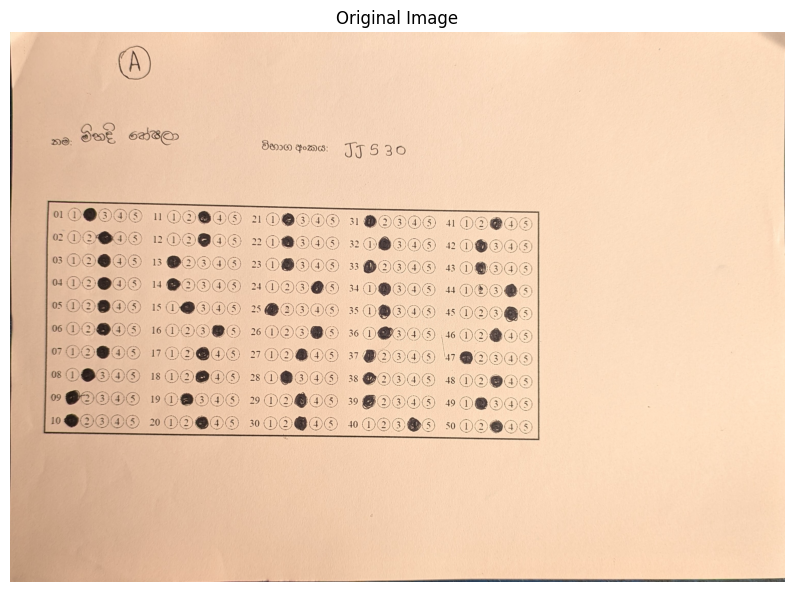

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('Data Set\Answer Scripts\Answer Scripts\A\JJ530.jpg')

# Use matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")  # Hide axes for better viewing
plt.show()

### Finding sheet corners

In [2]:
def find_sheet_corners(image):
    # Convert to grayscale and apply Gaussian blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection
    edged = cv2.Canny(blurred, 50, 150)

    # Find contours in the edged image
    contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the answer sheet
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the contour to find the corners
    perimeter = cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)

    if len(corners) == 4:
        return corners.reshape(4, 2)
    else:
        raise ValueError("Could not find the corners of the sheet")


# Find the corners of the sheet
sheet_corners = find_sheet_corners(image)

print(sheet_corners)


#cv2.waitKey(0)
#cv2.destroyAllWindows()

[[ 148  658]
 [ 133 1564]
 [2064 1591]
 [2064  700]]


## Warp image to a known aspect ratio

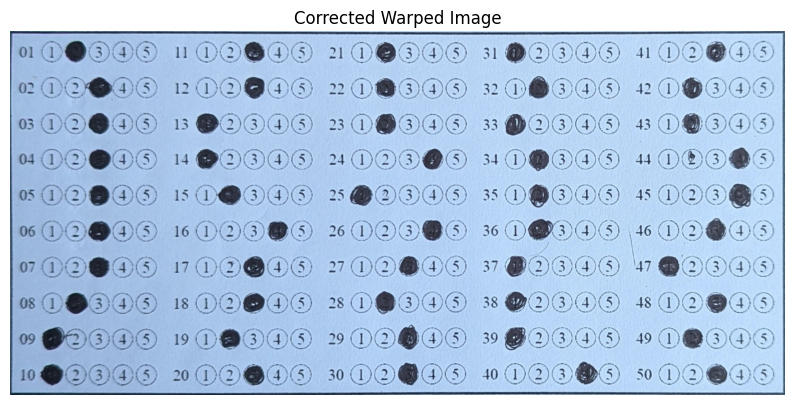

In [3]:
def warp_perspective(image, corners):
    # Define the known aspect ratio for the warped image (standard OMR sheet size)
    top_left, top_right, bottom_right, bottom_left = corners

    width = max(np.linalg.norm(top_right - top_left), np.linalg.norm(bottom_right - bottom_left))
    height = max(np.linalg.norm(top_right - bottom_right), np.linalg.norm(top_left - bottom_left))

    # Destination points for the warp
    destination_corners = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")

    # Perspective transform matrix
    M = cv2.getPerspectiveTransform(corners.astype(np.float32), destination_corners)
    warped = cv2.warpPerspective(image, M, (int(width), int(height)))

    return warped

# Warp the perspective to a known aspect ratio
warped_image = warp_perspective(image, sheet_corners)

# Optionally save or display the warped image
#cv2.imshow("Warped Image", warped_image)

# Rotate the image by 90 degrees clockwise to correct the orientation
warped_image_rotated = cv2.rotate(warped_image, cv2.ROTATE_90_CLOCKWISE)

# Flip the image horizontally to fix the mirroring
warped_image_corrected = cv2.flip(warped_image_rotated, 1)

# Convert the image to RGB for displaying with Matplotlib
warped_image_rgb = cv2.cvtColor(warped_image_corrected, cv2.COLOR_BGR2RGB)

# Use matplotlib to display the image
plt.figure(figsize=(10, 10))
plt.imshow(warped_image_rgb)
plt.title("Corrected Warped Image")
plt.axis("off")  # Hide axes for better viewing
plt.show()



## Gridded answer sheet

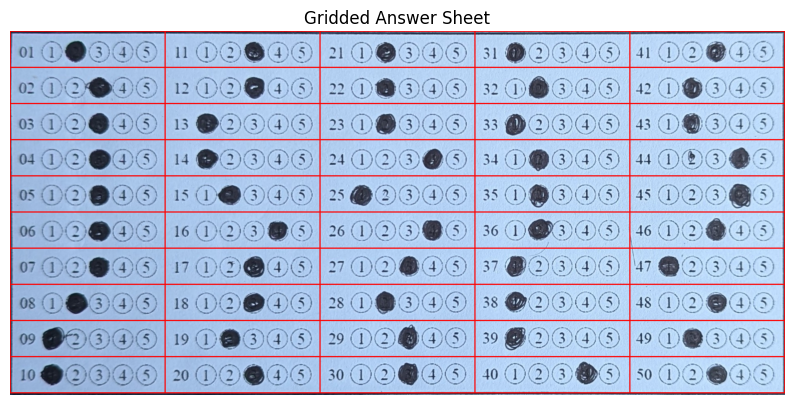

In [4]:
def create_grid(image, num_questions=10, num_options=5):
    # Get the image dimensions
    height, width = image.shape[:2]

    # Define the cell size based on number of questions and options
    cell_height = height // num_questions
    cell_width = width // num_options

    # List to store grid coordinates for each bubble
    grid = []

    for i in range(num_questions):
        row = []
        for j in range(num_options):
            # Define the top-left and bottom-right corners of each cell
            top_left = (j * cell_width, i * cell_height)
            bottom_right = ((j + 1) * cell_width, (i + 1) * cell_height)

            row.append((top_left, bottom_right))

        grid.append(row)

    return grid

# Create a grid on the image (10 rows, 5 columns)
grid = create_grid(warped_image_corrected, num_questions=10, num_options=5)

# display the grid on the image for verification
for row in grid:
    for (top_left, bottom_right) in row:
        cv2.rectangle(warped_image_corrected, top_left, bottom_right, (0, 0, 255), 2)

# Display the image with the grid
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(warped_image_corrected, cv2.COLOR_BGR2RGB))
plt.title("Gridded Answer Sheet")
plt.axis("off")
plt.show()

## Generating anwers of the student

Question 1: Option 2
Question 2: Option 3
Question 3: Option 3
Question 4: Option 3
Question 5: Option 3
Question 6: Option 3
Question 7: Option 3
Question 8: Option 2
Question 9: Option 1
Question 10: Option 1
Question 11: Option 3
Question 12: Option 3
Question 13: Option 1
Question 14: Option 1
Question 15: Option 2
Question 16: Option 4
Question 17: Option 3
Question 18: Option 3
Question 19: Option 2
Question 20: Option 3
Question 21: Option 2
Question 22: Option 2
Question 23: Option 2
Question 24: Option 4
Question 25: Option 1
Question 26: Option 4
Question 27: Option 3
Question 28: Option 2
Question 29: Option 3
Question 30: Option 3
Question 31: Option 1
Question 32: Option 2
Question 33: Option 1
Question 34: Option 2
Question 35: Option 2
Question 36: Option 2
Question 37: Option 1
Question 38: Option 1
Question 39: Option 1
Question 40: Option 4
Question 41: Option 3
Question 42: Option 2
Question 43: Option 2
Question 44: Option 4
Question 45: Option 4
Question 46: Option

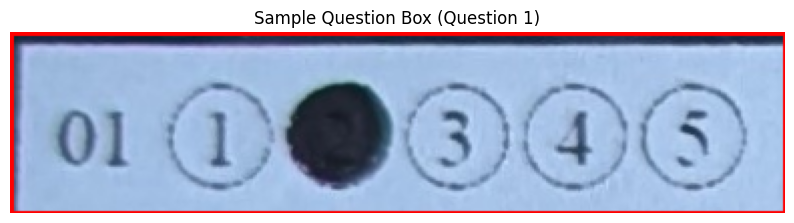

In [5]:
def extract_question_boxes(image, num_columns=5, num_rows=10):
    """
    Extract individual question boxes from the gridded answer sheet.
    There are num_columns columns and num_rows rows.
    """
    height, width = image.shape[:2]
    
    # Calculate width and height of each grid box
    box_width = width // num_columns
    box_height = height // num_rows
    
    question_boxes = []
    for col in range(num_columns):
        for row in range(num_rows):
            top_left = (col * box_width, row * box_height)
            bottom_right = ((col + 1) * box_width, (row + 1) * box_height)
            
            # Extract the grid box corresponding to each question
            question_box = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
            question_boxes.append(question_box)
    
    return question_boxes

def detect_colored_bubble(question_box):
    """
    Detect the filled bubble in the given question box.
    The question box is divided into 6 sections (1 for question number, 5 for bubbles).
    """
    # Convert to grayscale for processing
    gray_box = cv2.cvtColor(question_box, cv2.COLOR_BGR2GRAY)

    # Apply threshold to detect dark bubbles
    _, thresh_box = cv2.threshold(gray_box, 150, 255, cv2.THRESH_BINARY_INV)

    # Split the question box into 6 equal sections (1 for question number and 5 for bubbles)
    bubble_width = question_box.shape[1] // 6
    filled_bubbles = []

    for i in range(1, 6):  # Start from index 1 to skip the question number
        # Extract each bubble section
        bubble_region = thresh_box[:, i * bubble_width: (i + 1) * bubble_width]
        
        # Calculate the filled area percentage in each bubble
        filled_percentage = np.sum(bubble_region == 255) / float(bubble_region.size)
        filled_bubbles.append(filled_percentage)

    # Identify the index of the most filled bubble
    filled_bubble_index = np.argmax(filled_bubbles) + 1  # Add 1 to get options 1-5
    return filled_bubble_index

# Load the corrected warped image
warped_image = warped_image_corrected

# Extract the 50 grid boxes corresponding to the 50 questions
question_boxes = extract_question_boxes(warped_image, num_columns=5, num_rows=10)

# Process each question box and detect the filled bubble
results = []

for i, question_box in enumerate(question_boxes):
    # Detect the filled bubble in each question box
    filled_bubble = detect_colored_bubble(question_box)

    # Store the question number (i + 1) and detected filled bubble
    question_number = i + 1
    results.append((question_number, filled_bubble))
    
    # Print the result for each question
    print(f"Question {question_number}: Option {filled_bubble}")

# Optionally, visualize one of the question boxes for reference
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(question_boxes[0], cv2.COLOR_BGR2RGB))
plt.title("Sample Question Box (Question 1)")
plt.axis("off")
plt.show()

## Saving to a CSV

In [6]:
import pandas as pd

# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=["q_no", "option"])

# Save the DataFrame to a CSV file
csv_file_path = 'final_grades/output_test_1.csv'
df_results.to_csv(csv_file_path, index=False)

print(f"Results saved to {csv_file_path}")

Results saved to final_grades/output_test_1.csv


C:\Users\Samudra\AppData\Local\Temp\ipykernel_27848\4035510661.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Grading process

In [8]:
import csv

# Load detected answers (from the MCQ answer detection)
def load_detected_answers(detected_answers_csv):
    detected_answers = {}
    with open(detected_answers_csv, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            q_no = int(row['q_no'])
            option = int(row['option'])
            detected_answers[q_no] = option
    return detected_answers

# Load the marking scheme (contains correct answers and conditions)
def load_marking_scheme(marking_scheme_csv):
    marking_scheme = {}
    with open(marking_scheme_csv, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            q_no = int(row['Question ID'])
            correct_answers = row['Answer ID'].split(',')
            condition = row['Condition']
            marking_scheme[q_no] = {
                'correct_answers': [int(ans) for ans in correct_answers],
                'condition': condition
            }
    return marking_scheme

# Grading logic
def grade(detected_answers, marking_scheme):
    results = []
    for q_no, correct_data in marking_scheme.items():
        correct_answers = correct_data['correct_answers']
        condition = correct_data['condition']
        detected_answer = detected_answers.get(q_no, None)

        # Default result: incorrect
        result = {'Question': q_no, 'Correct': False}

        if detected_answer is not None:
            if condition == '-':  # Single correct answer
                result['Correct'] = detected_answer in correct_answers
            elif condition == 'Any':  # Any of the answers is correct
                result['Correct'] = detected_answer in correct_answers
            elif condition == 'All':  # All answers must be selected
                # Check if detected answer matches all correct answers
                result['Correct'] = set(correct_answers) == {detected_answer}

        results.append(result)
    return results

# Save grading results to CSV
def save_grading_results(results, output_csv):
    with open(output_csv, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Question', 'Correct'])
        writer.writeheader()
        writer.writerows(results)

# Paths to CSV files
detected_answers_csv = 'final_grades/output_test_1.csv'  # Detected answers
marking_scheme_csv = 'Data Set/Marking Schemes/Marking Schemes/A.csv'   # Provided marking scheme
output_grades_csv = 'graded_output.csv'     # Output file

# Load data
detected_answers = load_detected_answers(detected_answers_csv)
marking_scheme = load_marking_scheme(marking_scheme_csv)

# Perform grading
results = grade(detected_answers, marking_scheme)

# Save results to CSV
save_grading_results(results, output_grades_csv)

print("Grading completed. Results saved to:", output_grades_csv)

Grading completed. Results saved to: graded_output.csv


## Output marks as well

In [9]:
import csv

# Load detected answers (from the MCQ answer detection)
def load_detected_answers(detected_answers_csv):
    detected_answers = {}
    with open(detected_answers_csv, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            q_no = int(row['q_no'])
            option = int(row['option'])
            detected_answers[q_no] = option
    return detected_answers

# Load the marking scheme (contains correct answers and conditions)
def load_marking_scheme(marking_scheme_csv):
    marking_scheme = {}
    with open(marking_scheme_csv, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            q_no = int(row['Question ID'])
            correct_answers = row['Answer ID'].split(',')
            condition = row['Condition']
            marking_scheme[q_no] = {
                'correct_answers': [int(ans) for ans in correct_answers],
                'condition': condition
            }
    return marking_scheme

# Grading logic
def grade(detected_answers, marking_scheme):
    results = []
    # Initialize the total marks
    total_marks = 0
    for q_no, correct_data in marking_scheme.items():
        correct_answers = correct_data['correct_answers']
        condition = correct_data['condition']
        detected_answer = detected_answers.get(q_no, None)

        # Default result: incorrect
        result = {'Question': q_no, 'Correct': False}

        if detected_answer is not None:
            if condition == '-':  # Single correct answer
                if detected_answer in correct_answers:
                    result['Correct'] = True
                    total_marks += 1  # Only add marks if the answer is correct
            elif condition == 'Any':  # Any of the answers is correct
                if detected_answer in correct_answers:
                    result['Correct'] = True
                    total_marks += 1
            elif condition == 'All':  # All answers must be selected
                # Check if detected answer matches all correct answers
                if set(correct_answers) == {detected_answer}:
                    result['Correct'] = True
                    total_marks += 1

        results.append(result)
    
    # Display total marks out of 50
    print(f"Total Marks: {total_marks}/50")
    return results

# Save grading results to CSV
def save_grading_results(results, output_csv):
    with open(output_csv, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Question', 'Correct'])
        writer.writeheader()
        writer.writerows(results)

# Paths to CSV files
detected_answers_csv = 'final_grades/output_test_1.csv'  # Detected answers
marking_scheme_csv = 'Data Set/Marking Schemes/Marking Schemes/A.csv'   # Provided marking scheme
output_grades_csv = 'graded_output.csv'     # Output file

# Load data
detected_answers = load_detected_answers(detected_answers_csv)
marking_scheme = load_marking_scheme(marking_scheme_csv)

# Perform grading
results = grade(detected_answers, marking_scheme)

# Save results to CSV
save_grading_results(results, output_grades_csv)

print("Grading completed. Results saved to:", output_grades_csv)

Total Marks: 24/50
Grading completed. Results saved to: graded_output.csv
